# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нам нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

**Цель исследования** — построить модель машинного обучения, способную прогнозировать количество заказов на такси на один час вперёд, с точностью, обеспечивающей значение метрики RMSE не выше 48 на тестовой выборке.

**Задачи исследования:**  

1. Загрузить и предварительно обработать данные.  
2. Провести ресемплирование данных по одному часу.  
3. Исследовать и визуализировать временные ряды.   
4. Обучить несколько моделей с различными гиперпараметрами.  
5. Сравнить качество моделей с использованием метрики RMSE.  
6. Выбрать наилучшую модель и сделать финальное предсказание.  
7. Оценить качество финальной модели на тестовой выборке.  
8. Сделать выводы и рекомендации по использованию модели.  

**Описание данных:**

В распоряжении находятся исторические данные о количестве заказов такси.  

- Файл: `/datasets/taxi.csv`
- Признаки:
  - `datetime` — дата и время;
  - `num_orders` — количество заказов такси за указанный момент времени.

In [1]:
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
# подгружаем нужные библиотеки 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

## Загрузка данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates =[0], index_col= 0)

In [3]:
# функция для получения базовой информации о датасетах

def get_info(df):
    print("Размер датасета:", df.shape, sep='\n', end='\n\n')
    display(df)
    print('\n')
    display(df.info())
    print('\n')
    display(df.describe().T)
    print("Количество пропусков:", df.isna().sum(), sep='\n', end='\n\n')
    print("Количество явных дубликатов:", df.duplicated().sum(), end='\n\n')
    display(df[df.duplicated() == True])

In [4]:
get_info(df)

Размер датасета:
(26496, 1)



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Количество пропусков:
num_orders    0
dtype: int64

Количество явных дубликатов: 26415



,num_orders
datetime,
2018-03-01 02:10:00,12
2018-03-01 02:20:00,19
2018-03-01 03:00:00,8
2018-03-01 03:10:00,17
2018-03-01 03:20:00,7
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Пропуски отсутствуют. Рассемплируем по одному часу. 

In [5]:
df.index.is_monotonic

True

In [6]:
df = df.resample('1H').sum()

## Анализ данных

In [7]:
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = (14, 4)

In [8]:
def plot_series(series, title):
    plt.plot(series, linewidth=2, color='steelblue')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Время')
    plt.ylabel('Количество заказов')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [9]:
result = seasonal_decompose(df)

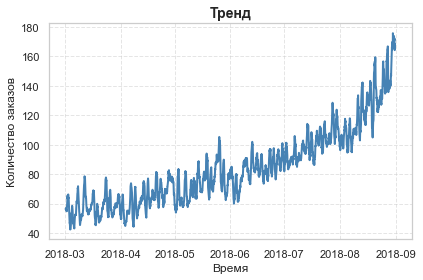

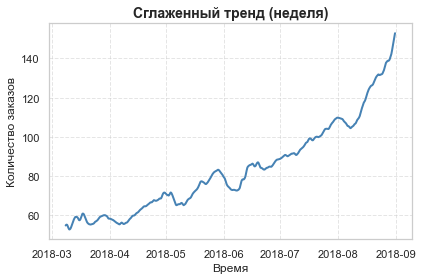

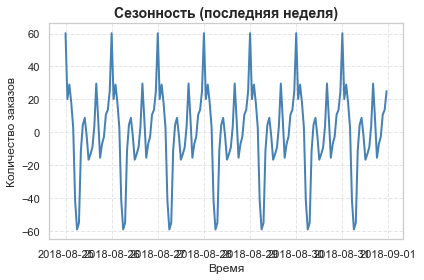

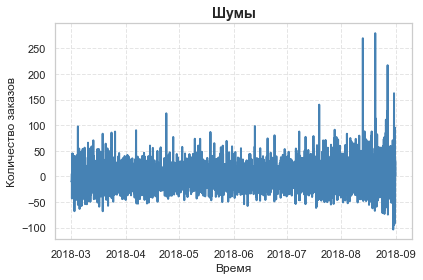

In [10]:
plot_series(result.trend, 'Тренд')
plot_series(result.trend.rolling(window=24*7).mean(), 'Сглаженный тренд (неделя)')
plot_series(result.seasonal.tail(24*7), 'Сезонность (последняя неделя)')
plot_series(result.resid, 'Шумы')

Можно сделать следующие выводы:	 

1. Наблюдается явный положительный тренд — количество заказов растёт со временем. Это говорит о том, что модель должна учитывать общий рост популярности сервиса (например, за счёт трендовых признаков - номер недели, месяца и тд).  

2. Сглаженный тренд подчеркивает устойчивый рост заказов, особенно в последние месяцы.  

3. Видна четкая недельная сезонность, выраженная резкими пиками и падениями. Вероятно, пик заказов приходится на выходные или будние дни в определнные часы  

4. Шумовая компонента содержит много выбросов, особенно в последние месяцы, где наблюдаются резкие всплески и падения. Это говорит о том, что часть колебаний не объясняется трендом и сезонностью — могут быть внешние или случайные факторы.  

## Обучение модели

<Figure size 720x432 with 0 Axes>

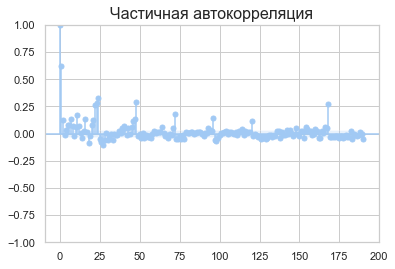

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(df['num_orders'], lags=190, method='ywm', alpha=0.05)
plt.title("Частичная автокорреляция", fontsize=16)
plt.show()

In [12]:
def extract_time_features(df):
    df = df.copy()
    df["weekday"] = df.index.dayofweek
    df["hour"]    = df.index.hour

    # 1, 2, 3, 24, 36, 48, 168
    selected_lags = list(range(1, 4)) + [24, 36, 48, 168]
    for lag in selected_lags:
        df[f"lag_{lag}"] = df["num_orders"].shift(lag)

    # скользящее средне
    df["rolling_avg_24h"] = df["num_orders"].shift(1).rolling(window=24).mean()

    df.dropna(inplace=True)
    return df

learning_df = extract_time_features(df)

**Исправила на первые 3 лага, 24, 48, 168. Я пробовала взять первые 12, но в таком случае модели обучаются очень долго. LGBM, например, дольше часа.**

**Так как месяц не нужен (годовая сезонность, данные только за полгода), его удалила. Оставляем только день недели и час. Также создала лаги на 1ч, 24ч и 168ч (неделя), так как это видно из автокорреляции**

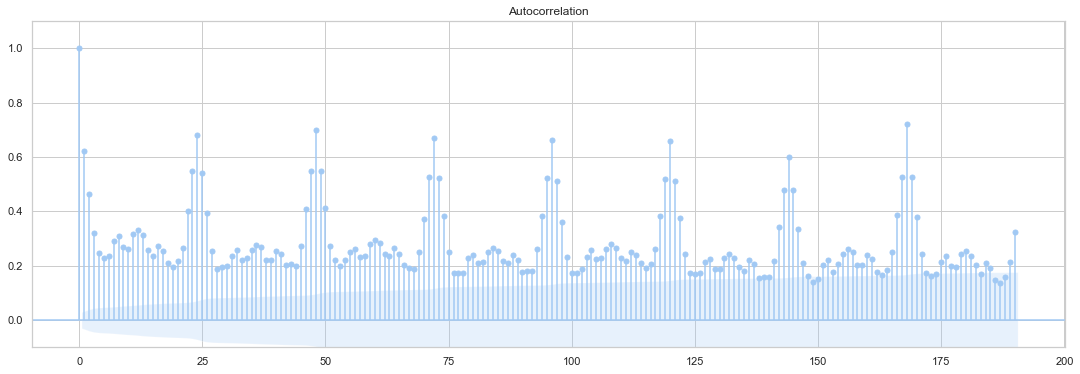

In [13]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [14]:
X = learning_df.drop(['num_orders'], axis=1)
y = learning_df['num_orders'] 

In [15]:
# тестовая выборка 10% от исходных данных в требовании проекта

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

### Линейная регрессия

In [16]:
models = []

In [17]:
tscv = TimeSeriesSplit(n_splits=3)

linear_model = LinearRegression()

cv_scores = cross_val_score(
    linear_model, X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=tscv
)

train_rmse = round(np.mean(-cv_scores)**0.5, 2)

print(f"Среднее RMSE по кросс валидации для Linear Regression: {train_rmse}")

linear_model.fit(X_train, y_train)
models.append([linear_model, train_rmse])

Среднее RMSE по кросс валидации для Linear Regression: 23.44


### Случайный лес

In [18]:
forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': range(60, 121, 20), 
    'max_depth': [3, 5, 7, 9]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(estimator=forest_model, param_grid=param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

train_preds_rf = grid_search.predict(X_train)
train_rmse_rf = mean_squared_error(y_train, train_preds_rf, squared=False)

models.append([grid_search.best_estimator_, train_rmse_rf, grid_search.best_params_])

print(f"RMSE для RandomForestRegressor на трейне: {train_rmse_rf:.2f}")
print(f"Лучшие гиперпараметры: {grid_search.best_params_}")

RMSE для RandomForestRegressor на трейне: 18.21
Лучшие гиперпараметры: {'max_depth': 7, 'n_estimators': 60}


### CatBoost

In [19]:
catboost_model = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

param_grid = {
    'iterations': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7, 10]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search_catboost = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_catboost.fit(X_train, y_train)
train_preds_cb = grid_search_catboost.predict(X_train)
train_rmse_cb = mean_squared_error(y_train, train_preds_cb, squared=False)

models.append([grid_search_catboost.best_estimator_, train_rmse_cb, grid_search_catboost.best_params_])

print(f"Среднее RMSE для CatBoostRegressor на трейне: {train_rmse_cb:.2f}")
print(f"Лучшие гиперпараметры: {grid_search_catboost.best_params_}")

Среднее RMSE для CatBoostRegressor на трейне: 18.93
Лучшие гиперпараметры: {'depth': 5, 'iterations': 300, 'learning_rate': 0.05}


### LGBM

In [20]:
lgb_model = lgb.LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'num_leaves': [31, 50, 70]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_lgb.fit(X_train, y_train)
train_preds_lgb = grid_search_lgb.predict(X_train)
train_rmse_lgb = mean_squared_error(y_train, train_preds_lgb, squared=False)

models.append([grid_search_lgb.best_estimator_, train_rmse_lgb, grid_search_lgb.best_params_])

print(f"Среднее RMSE для LGBMRegressor на трейне: {train_rmse_lgb:.2f}")
print(f"Лучшие гиперпараметры: {grid_search_lgb.best_params_}")

Среднее RMSE для LGBMRegressor на трейне: 18.14
Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}


### Итог

In [21]:
result_df = pd.DataFrame(models, columns=['model', 'rmse_train', 'best_params'])
result_df['model_name'] = result_df['model'].apply(lambda x: type(x).__name__)
result_df = result_df[['model_name', 'rmse_train', 'best_params']]
result_df['rmse_train'] = result_df['rmse_train'].round(2)
pd.options.display.max_colwidth = None

display(result_df.sort_values(by='rmse_train').reset_index(drop=True))

,model_name,rmse_train,best_params
0,LGBMRegressor,18.14,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}"
1,RandomForestRegressor,18.21,"{'max_depth': 7, 'n_estimators': 60}"
2,CatBoostRegressor,18.93,"{'depth': 5, 'iterations': 300, 'learning_rate': 0.05}"
3,LinearRegression,23.44,None


Лучший результат показала модель LGBM с RMSE 17.42 < 48 и параметрами {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}. Линейная регрессия все равно значительно проигрывает LGBM, соучайному лесу и CatBoost. Для прогона на тесте предлагаю взять только эти модели.

## Проверка на тестовой выборке

In [22]:
models_to_test = ['LGBMRegressor']

test_models = []

def display_result(target, pred, rmse):
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)
    print(f"RMSE = {rmse:.2f}")

In [23]:
for idx, entry in enumerate(models):
    model = entry[0]
    model_name = type(model).__name__

    if model_name in models_to_test:
        predictions = model.predict(X_test)
        rmse = mean_squared_error(y_test, predictions, squared=False)

        display_result(y_test, predictions, rmse)
        test_models.append(rmse)
        
result_df_filtered = result_df[result_df['model_name'].isin(models_to_test)].copy()
result_df_filtered['rmse_test'] = test_models

RMSE = 39.70


In [24]:
result_sorted = result_df_filtered.sort_values(by='rmse_test').reset_index(drop=True)
display(result_sorted)

,model_name,rmse_train,best_params,rmse_test
0,LGBMRegressor,18.14,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}",39.704063


## Вывод

В ходе работы над данным проектом был изучен датасет taxi.csv, который содержит дату и время заказа такси, а также количество заказов. Мы рассемплировали время по часам и провели анализ временных рядов. Анализ временных рядов показал явный положительный тренд роста заказов с выраженной недельной сезонностью и шумами, которые могут быть обусловлены внешними или случайными факторами.  

Далее были обучены 4 модели для предсказания количества заказов в следующий час: линейная регрессия, RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Был произведен поиск лучших гиперпараметров по сетке, модели выдали следующие результаты:

In [25]:
display(result_df.sort_values(by='rmse_train').reset_index(drop=True))

,model_name,rmse_train,best_params
0,LGBMRegressor,18.14,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}"
1,RandomForestRegressor,18.21,"{'max_depth': 7, 'n_estimators': 60}"
2,CatBoostRegressor,18.93,"{'depth': 5, 'iterations': 300, 'learning_rate': 0.05}"
3,LinearRegression,23.44,None


Далее мы прогнали тестовую выборку, которая составляет 10% от исходных данных, через обученные модели. Результаты вышли следующими:

In [26]:
result_sorted

,model_name,rmse_train,best_params,rmse_test
0,LGBMRegressor,18.14,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}",39.704063


**В финале оставила только LGBM как лучшую модель.**

**Поскольку на заказы такси могут влиять различные внешние факторы (погода, праздники, акции сервиса и т.д.), тестовая выборка включает больше "шумов", не представленных в трейне. Отсюда и ошибка на тестовой выборке может быть больше, чем на тренировочной.**

In [27]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1] 

rmse_naive = mean_squared_error(y_test, pred_previous, squared=False)
print(f"RMSE наивной модели: {rmse_naive:.2f}")

RMSE наивной модели: 58.82


RMSE наивной модели составил 58.82, что заметно хуже качества построенных моделей и не проходит критерий верхнего допустимого порога RMSE = 48 => к использованию рекомендуются уже обученные модели.

**Таким образом, беря во внимание критерий заказчика об ошибке модели RMSE < 48, предлагаю к использованию модель LGBMRegressor. Она показала наименьшую ошибку RMSE = 39.7 на тесте и RMSE = 18.1 на тренировочной выборке, идеально подходит для данного проекта**